In [ ]:
# Please install these separately if necessary. For some reason installed gensim will ruin numpy
# Which doesn't make a lot of sense...
# However, the code has worked even without the importing of these libraries in other instances of using Colab.
#!pip install gensim
#!pip install tensorflow
#!pip install numpy

# 1. Data Exploration

Below is the entirety of what is asked for, for sampling and exploring the data to understand what each column is made of. The print statements include some clarifying statements to make it a little more visible to pick out key information.

In [ ]:

# Student Names and Numbers
# Jayden Brar = 501098365
# Abdalla Elgharbawy = 501037562

# It is crucial that if running this in Colab, that you change the runtime type to GPU T4
# a pip install and earlier import for regex
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# I import the nltk libraries early as they take a while to import
!pip install nltk
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize


# Here I import data.csv as a pd data frame

import pandas as pd

# No file path necessary
df = pd.read_csv('data.csv')

from google.colab import data_table
data_table.enable_dataframe_formatter()

# Now I can work with the data in the DataFrame 'df'.
# I printed the first ten rows without colwidth limit so I can fully understand the formatting of the data

pd.set_option('display.max_colwidth', None)
print(df.head(10))

# Print a unique set of the items written in the 'Class Index' field
print(set(' '.join(df['Class Index'].astype(str)).split()))

# Obtain & print a list of terms used within brackets for text cleaning used later
from collections import Counter

def extract_words_in_parentheses(text):
    words = re.findall(r"\((.*?)\)", text)
    return words

bracket_words = []
for text in df['Title']:  # Changed to df['Title']
    words = extract_words_in_parentheses(text)
    bracket_words.extend(words)

word_counts = Counter(bracket_words)

news_articles = [word for word, count in word_counts.items() if count > 5]

less_bracketed = [word for word, count in word_counts.items() if count <= 5]


# Here's a print out of all news articles, then of all words found in brackets
# This will also be the "additional statistic of our choice"
print(' ')
print("News Articles Total:", len(news_articles), news_articles)
print("Less common words:", less_bracketed)

# Number of samples per category
category_counts1 = df['Title'].value_counts()
category_counts2 = df['Description'].value_counts()
print(' ')
print('Number of Samples per Category Title:', category_counts1)
print(' ')
print('Number of Samples per Category Description:', category_counts2)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


          Class Index  \
0  science/technology   
1               sport   
2               sport   
3               sport   
4               sport   
5               sport   
6               sport   
7               sport   
8               sport   
9               sport   

                                                                       Title  \
0                          Wall St. Bears Claw Back Into the Black (Reuters)   
1                        Carlyle Looks Toward Commercial Aerospace (Reuters)   
2                            Oil and Economy Cloud Stocks' Outlook (Reuters)   
3               Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)   
4  Oil prices soar to all-time record, posing new menace to US economy (AFP)   
5                                Stocks End Up, But Near Year Lows (Reuters)   
6                                       Money Funds Fell in Latest Week (AP)   
7                     Fed minutes show dissent over inflation (USATODAY.com)   
8   

^ this is in regards to the above output.

We were able to identify the following things:
*   Class_index is only composed of sport and science/technology as binary options.
*   The unique set of news articles mentioned 6 times or more.
*   The unique set of items contained within brackets found inside the data that are mentioned 6 times or less (these were all confirmed to not be news sources, or mentioned so infrequently that they are sparse).
*   The formatting of the dataset in the top 10 rows for all columns.
*   The method of obtaining this data left in the news articles inside brackets.
*   The data is very messy and many characters and links need to be removed.
*   There would be no effective way to remove all the back-end UML codes without also removing helpful numbers that may help topic model.
*   The "less common words" list is full of odd phrases that should be removed.





# 2. Data Cleaning

There was a very interesting portion of the Title/Description column where they include the news source the article comes from. Typically news sources have their "popular topics", which may make it easier for the model to accurately group the news articles. As if I were guessing what topic the news article is about, the news source being Reuters would tell me almost certainly that it's tangentially related to finance.

In [ ]:
# Here I will do some basic pre-processing to make the duplication check easier and a little more reliable
# I will be intentionally leaving in the news publication name in a new column as they could be used to more accurately topic model
# News publications have their specific fields or niches, which means that having "Reuters" as a word in the sentence
# could help signal what the topic is about
# However, this is best measured via trial-and-error based on model performance
# So I will make new columns to handle this

def separate_news_articles(text):
  return re.sub(r"\(.*?\)", "", text)

# I name the new column Title W/O News for WITHOUT NEWS PUBLICATIONS
# It is important to note that the method of cleaning the news articles at this point is just to remove text within parentheses
# This method of removal may leave un-bracketed mentions which we will clean later
# It is important to note that 'Description' does not use as many parentheses, making the next cleaning process even more vital
df['Title W/O News'] = df['Title'].apply(separate_news_articles)
df['Description W/O News'] = df['Description'].apply(separate_news_articles)
df

,Class Index,Title,Description,Title W/O News,Description W/O News
0,science/technology,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",Wall St. Bears Claw Back Into the Black,"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,sport,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",Carlyle Looks Toward Commercial Aerospace,"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,sport,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,Oil and Economy Cloud Stocks' Outlook,Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,sport,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",Iraq Halts Oil Exports from Main Southern Pipeline,"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,sport,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.","Oil prices soar to all-time record, posing new menace to US economy","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."
...,...,...,...,...,...
59995,sport,"Despite Mega-Deals, Small Mergers Rule","Philadelphia (Reuters) - Despite the euphoria of one of the busiest weeks in U.S. mergers and acquisitions in almost five years, Wall Street investment bankers cannot live by mega-deals alone.","Despite Mega-Deals, Small Mergers Rule","Philadelphia - Despite the euphoria of one of the busiest weeks in U.S. mergers and acquisitions in almost five years, Wall Street investment bankers cannot live by mega-deals alone."
59996,sport,Wal-Mart Dec. Sales Still Seen Up 1-3 Pct,"CHICAGO (Reuters) - Wal-Mart Stores Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=WMT.N target=/stocks/quickinfo/fullquote""&gt;WMT.N&lt;/A&gt; said on Saturday it still expects a 1 percent to 3 percent increase in December sales at its U.S. stores open at least a year as sales of general merchandise and winter items improved in the latest week.",Wal-Mart Dec. Sales Still Seen Up 1-3 Pct,"CHICAGO - Wal-Mart Stores Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=WMT.N target=/stocks/quickinfo/fullquote""&gt;WMT.N&lt;/A&gt; said on Saturday it still expects a 1 percent to 3 percent increase in December sales at its U.S. stores open at least a year as sales of general merchandise and winter items improved in the latest week."
59997,sport,Sabotage Stops Iraq's North Oil Exports,"BAGHDAD (Reuters) - Saboteurs blew up Iraq's northern export pipeline for the second week in a row on Saturday, halting oil flows to Turkey's Ceyhan port, oil officials said.",Sabotage Stops Iraq's North Oil Exports,"BAGHDAD - Saboteurs blew u

More extensive text cleaning from the list here is:
Convert text to lowercase.
Remove punctuation, special characters, and numbers.

This also features link removal, and some unique phrases that were found in the dataset through manual inspection that refer to links but are not an entire link.

The purpose of removing these is as such: they serve no purpose to human readers in a way that would add context. While it is theoretically possible that all documents containing isolated phrases like "href" may lead to healthcare articles, it is not logically reasonable to assume so. Thus, it is highly reasonable to remove it without using compute to test the minute differences between models.

In [ ]:
# Below is a regex based text cleaning
# The text cleaning in this project is done in phases as it is extensive and tailored to the problems of this database
# This project fuses multiple libraries together to maximize data density and create highly contextual documents
# This should aid in LDA topic modelling by removing useless and off-topic phrases/words in mass

def clean_text(text):
  if isinstance(text, str):
    text = text.lower()  # Lowercase the text
    text = re.sub(r'\\', " ", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special characters
    text = text.replace("'", "")  # Remove apostrophes
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    text = text.replace('"', '') # Remove quotations as many documents had these
    text = re.sub(r"http\S+", "", text)  # Removes links starting with "http"
    text = re.sub(r"www\S+", "", text)  # Removes links starting with "www"
    text = re.sub(r"href\S+", "", text)  # Removes links starting with "href" as found in data
    text = re.sub(r"http", "", text)  # Removes links starting with "http" in isolation
    text = re.sub(r"www", "", text)  # Removes links starting with "www" in isolation
    text = re.sub(r"href", "", text)  # Removes links starting with "href" as found in data in isolation
    text = re.sub(r'\d+', '', text)  # Replace one or more digits with an empty string, removing numbers specifically


  return text

df['Title'] = df['Title'].apply(clean_text)
df['Title W/O News'] = df['Title W/O News'].apply(clean_text)
df['Description'] = df['Description'].apply(clean_text)
df['Description W/O News'] = df['Description'].apply(clean_text)

df

,Class Index,Title,Description,Title W/O News,Description W/O News
0,science/technology,wall st bears claw back into the black reuters,reuters shortsellers wall streets dwindling band of ultracynics are seeing green again,wall st bears claw back into the black,reuters shortsellers wall streets dwindling band of ultracynics are seeing green again
1,sport,carlyle looks toward commercial aerospace reuters,reuters private investment firm carlyle group which has a reputation for making welltimed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market,carlyle looks toward commercial aerospace,reuters private investment firm carlyle group which has a reputation for making welltimed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market
2,sport,oil and economy cloud stocks outlook reuters,reuters soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums,oil and economy cloud stocks outlook,reuters soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums
3,sport,iraq halts oil exports from main southern pipeline reuters,reuters authorities have halted oil export flows from the main pipeline in southern iraq after intelligence showed a rebel militia could strike infrastructure an oil official said on saturday,iraq halts oil exports from main southern pipeline,reuters authorities have halted oil export flows from the main pipeline in southern iraq after intelligence showed a rebel militia could strike infrastructure an oil official said on saturday
4,sport,oil prices soar to alltime record posing new menace to us economy afp,afp tearaway world oil prices toppling records and straining wallets present a new economic menace barely three months before the us presidential elections,oil prices soar to alltime record posing new menace to us economy,afp tearaway world oil prices toppling records and straining wallets present a new economic menace barely three months before the us presidential elections
...,...,...,...,...,...
59995,sport,despite megadeals small mergers rule,philadelphia reuters despite the euphoria of one of the busiest weeks in us mergers and acquisitions in almost five years wall street investment bankers cannot live by megadeals alone,despite megadeals small mergers rule,philadelphia reuters despite the euphoria of one of the busiest weeks in us mergers and acquisitions in almost five years wall street investment bankers cannot live by megadeals alone
59996,sport,walmart dec sales still seen up pct,chicago reuters walmart stores inc lta targetstocksquickinfofullquotegtwmtnltagt said on saturday it still expects a percent to percent increase in december sales at its us stores open at least a year as sales of general merchandise and winter items improved in the latest week,walmart dec sales still seen up pct,chicago reuters walmart stores inc lta targetstocksquickinfofullquotegtwmtnltagt said on saturday it still expects a percent to percent increase in december sales at its us stores open at least a year as sales of general merchandise and winter items improved in the latest week
59997,sport,sabotage stops iraqs north oil exports,baghdad reuters saboteurs blew up iraqs northern export pipeline for the second week in a row on saturday halting oil flows to turkeys ceyhan port oil officials said,sabotage stops iraqs north oil exports,baghdad reuters saboteurs blew up iraqs northern export pipeline for the second week in a row on saturday halting oil flows to turkeys ceyhan port oil officials said
59998,sport,corporate costcutters miss out,chicago reuters one of the mantras of global industry in recent years has been keeping inventories lean and mean but there are increasing s

Below is a specialized cleaning used to clean out less mentioned news articles as that would increase sparsity. Earlier I defined a list of words that appear 6 or less times, and the function below will clean the data set of all mentions of that list.

The specialized reasoning for removing these words and phrases are to remove things that we know for certain do not appear often. The format the data was extracted in essentially pulled out all these phrases for us. The less common words used inside the brackets had things that were not news articles, like "part 3 of 3".

In [ ]:
# Here I clean out a swathe of words I found in brackets as these words need to be specially cleaned in the non-"W/O" columns
# This will aid data sparsity as it will remove unnatural words/phrases that are not found commonly in articles
# This does remove a single article name or two from the column that is supposed to inlcude them, but that word would be sparse regardless

def clean_text_with_list(text, word_list):
    pattern = r'\b(' + '|'.join(word_list).lower() + r')\b'  # Create regex pattern, lower cases the list to match the lowered case of the doc
    cleaned_text = re.sub(pattern, '', text)  # Remove matching words
    return cleaned_text

def chunk_dataframe(df, chunk_size):
       for i in range(0, len(df), chunk_size):
           yield df[i:i + chunk_size]

# Chunking to allow it to process

def clean_text_column_with_chunking(df, column_name, word_list, chunk_size=1000):
    processed_chunks = []
    for chunk in chunk_dataframe(df, chunk_size):
        chunk[column_name] = chunk[column_name].apply(lambda x: clean_text_with_list(x, word_list))
        processed_chunks.append(chunk)
    return pd.concat(processed_chunks)[column_name]


df['Title'] = clean_text_column_with_chunking(df, 'Title', less_bracketed, chunk_size=1000)
df['Description'] = clean_text_column_with_chunking(df, 'Description', less_bracketed, chunk_size=1000)
# To ensure that there are absolutely no mentions of the news articles, I will specifically go through "wo" columns to clean them
df['Description W/O News'] = clean_text_column_with_chunking(df, 'Description W/O News', news_articles, chunk_size=1000)
df['Title W/O News'] = clean_text_column_with_chunking(df, 'Title W/O News', news_articles, chunk_size=1000)
df

<ipython-input-7-b21b51424e15>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[column_name] = chunk[column_name].apply(lambda x: clean_text_with_list(x, word_list))


,Class Index,Title,Description,Title W/O News,Description W/O News
0,science/technology,wall st bears claw back into the black reuters,reuters shortsellers wall streets dwindling band of ultracynics are seeing green,wall st bears claw back into the black,shortsellers wall streets dwindling band of ultracynics are seeing green again
1,sport,carlyle looks toward commercial aerospace reuters,reuters private investment firm carlyle group which has a reputation for making welltimed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market,carlyle looks toward commercial aerospace,private investment firm carlyle group which has a reputation for making welltimed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market
2,sport,oil and economy cloud stocks outlook reuters,reuters soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums,oil and economy cloud stocks outlook,soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums
3,sport,iraq halts oil exports from main southern pipeline reuters,reuters authorities have halted oil export flows from the main pipeline in southern iraq after intelligence showed a rebel militia could strike infrastructure an oil said on saturday,iraq halts oil exports from main southern pipeline,authorities have halted oil export flows from the main pipeline in southern iraq after intelligence showed a rebel militia could strike infrastructure an oil official said on saturday
4,sport,oil prices soar to alltime record posing new menace to economy afp,afp tearaway world oil prices toppling records and straining wallets present a new economic menace barely three months before the presidential elections,oil prices soar to alltime record posing new menace to us economy,tearaway world oil prices toppling records and straining wallets present a new economic menace barely three months before the us presidential elections
...,...,...,...,...,...
59995,sport,despite megadeals mergers rule,philadelphia reuters despite the euphoria of one of the busiest weeks in mergers and acquisitions in five years wall street investment bankers cannot live by megadeals alone,despite megadeals small mergers rule,philadelphia despite the euphoria of one of the busiest weeks in us mergers and acquisitions in almost five years wall street investment bankers cannot live by megadeals alone
59996,sport,walmart dec sales still seen up pct,chicago reuters walmart stores inc lta targetstocksquickinfofullquotegtwmtnltagt said on saturday it still expects a percent to percent increase in december sales at its stores open at least a year as sales of general merchandise and winter items improved in the latest week,walmart dec sales still seen up pct,chicago walmart stores inc lta targetstocksquickinfofullquotegtwmtnltagt said on saturday it still expects a percent to percent increase in december sales at its us stores open at least a year as sales of general merchandise and winter items improved in the latest week
59997,sport,sabotage stops iraqs north oil exports,baghdad reuters saboteurs blew up iraqs northern export pipeline for the second week in a row on saturday halting oil flows to turkeys ceyhan port oil officials said,sabotage stops iraqs north oil exports,baghdad saboteurs blew up iraqs northern export pipeline for the second week in a row on saturday halting oil flows to turkeys ceyhan port oil officials said
59998,sport,corporate costcutters miss out,chicago reuters one of the mantras of global industry in recent years has been keeping inventories lean and mean but there are increasing signs this costcutting strategy is creating strains and causing companies to miss out on sales,corpor

Here is another cleaning phase, from the list in step 2:
Remove stopwords.

I also dropped duplicate rows and rows with missing values in the next code block after confirming their existence in this one.

Duplicate rows can skew model performance by weighting certain inputs as highly similar, artificially increasing the minimized K value for the cluster.

Empty values are essentially value-less as they lack the same context that we expect to be inputting, and thus removal can aid model performance or simply increase compute efficiency.

Stopwords are removed as they're a natural requirement of the english language that largely do not depend on context. Thus the removal of them can greatly aid model performance by making the text dissimilar in a way that largely preserves core meaning (enough for topic modelling as it doesn't depend on individual word correlations).

LDA Topic Modelling also uses a similarly score in its calculations to measure performance. All documents would be artificially boosted in similarity score due to the matching stopwords between articles.

In [ ]:
# Here I clean do a clean of the df by applying word removal to the relevant columns
# This step is essentially in removal of words that are frequently written irrespective of topic
# Thus aiding in model performance

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return " ".join(filtered_words)

df['Title'] = df['Title'].apply(remove_stopwords)
df['Title W/O News'] = df['Title W/O News'].apply(remove_stopwords)
df['Description'] = df['Description'].apply(remove_stopwords)
df['Description W/O News'] = df['Description W/O News'].apply(remove_stopwords)

# Check for duplicate entries in the dataset, the removal of stopwords should aid this process by making overlap clearer

duplicate_rows = df[df.duplicated()]
if not duplicate_rows.empty:
  print("Duplicate entries found:")
  print(duplicate_rows)
else:
  print("No duplicate entries found.")

# Check for missing values

missing_values = df.isnull().sum()
if missing_values.any():
  print("Missing values found:")
  print(missing_values)
else:
  print("No missing values found.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Duplicate entries found:
              Class Index                                      Title  \
905                 sport        housing starts rebound sharply july   
948                 sport           july output factories run faster   
1020   science/technology  microsoft readies host integration server   
1051   science/technology   ibm adds fourway server new product line   
1114                sport              stocks end higher lifted data   
...                   ...                                        ...   
58297               sport    mortgage applications fell last weekmba   
59325  science/technology     spacecraft tracks global air pollution   
59346               sport      airways flight attendants closer deal   
59640               sport          lilly warns doctors strattera use   
59800               sport          exelon talks buy pse ampg sources   

                                                                                                              

In [ ]:
# Drop duplicate rows
df = df.drop_duplicates()

# Drop rows with missing values
df = df.dropna()

# Verify there are no remaining bad entries that would damage data integrity or density
# Check for duplicate entries in the dataset
# Duplicate entries can skew the topic modelling of the these documents as it will artificially inflate certain trends

duplicate_rows = df[df.duplicated()]
if not duplicate_rows.empty:
  print("Duplicate entries found:")
  print(duplicate_rows)
else:
  print("No duplicate entries found.")

# Check for missing values, despite not being found earlier, it is worth doing regardless to ensure no errors were caused along the way

missing_values = df.isnull().sum()
if missing_values.any():
  print("Missing values found:")
  print(missing_values)
else:
  print("No missing values found.")


No duplicate entries found.
No missing values found.


In [ ]:
# Dataframe check for visual clarity on instructor's marking end
df

,Class Index,Title,Description,Title W/O News,Description W/O News
0,science/technology,wall st bears claw back black reuters,reuters shortsellers wall streets dwindling band ultracynics seeing green,wall st bears claw back black,shortsellers wall streets dwindling band ultracynics seeing green
1,sport,carlyle looks toward commercial aerospace reuters,reuters private investment firm carlyle group reputation making welltimed occasionally controversial plays defense industry quietly placed bets another part market,carlyle looks toward commercial aerospace,private investment firm carlyle group reputation making welltimed occasionally controversial plays defense industry quietly placed bets another part market
2,sport,oil economy cloud stocks outlook reuters,reuters soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums,oil economy cloud stocks outlook,soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums
3,sport,iraq halts oil exports main southern pipeline reuters,reuters authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil said saturday,iraq halts oil exports main southern pipeline,authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil official said saturday
4,sport,oil prices soar alltime record posing new menace economy afp,afp tearaway world oil prices toppling records straining wallets present new economic menace barely three months presidential elections,oil prices soar alltime record posing new menace us economy,tearaway world oil prices toppling records straining wallets present new economic menace barely three months us presidential elections
...,...,...,...,...,...
59995,sport,despite megadeals mergers rule,philadelphia reuters despite euphoria one busiest weeks mergers acquisitions five years wall street investment bankers cannot live megadeals alone,despite megadeals small mergers rule,philadelphia despite euphoria one busiest weeks us mergers acquisitions almost five years wall street investment bankers cannot live megadeals alone
59996,sport,walmart dec sales still seen pct,chicago reuters walmart stores inc lta targetstocksquickinfofullquotegtwmtnltagt said saturday still expects percent percent increase december sales stores open least year sales general merchandise winter items improved latest week,walmart dec sales still seen pct,chicago walmart stores inc lta targetstocksquickinfofullquotegtwmtnltagt said saturday still expects percent percent increase december sales us stores open least year sales general merchandise winter items improved latest week
59997,sport,sabotage stops iraqs north oil exports,baghdad reuters saboteurs blew iraqs northern export pipeline second week row saturday halting oil flows turkeys ceyhan port oil officials said,sabotage stops iraqs north oil exports,baghdad saboteurs blew iraqs northern export pipeline second week row saturday halting oil flows turkeys ceyhan port oil officials said
59998,sport,corporate costcutters miss,chicago reuters one mantras global industry recent years keeping inventories lean mean increasing signs costcutting strategy creating strains causing companies miss sales,corporate costcutters miss,chicago one mantras global industry recent years keeping inventories lean mean increasing signs costcutting strategy creating strains causing companies miss sales


In [ ]:
# As the LDA topic modelling model will recognize each input as a single document
# I will combine the title and description rows then drop old ones

df['Combined Text'] = df['Title'] + ' ' + df['Description']
df['Combined Text W/O News'] = df['Title W/O News'] + ' ' + df['Description W/O News']
df = df.drop(columns=['Title', 'Description', 'Title W/O News', 'Description W/O News'])
df

,Class Index,Combined Text,Combined Text W/O News
0,science/technology,wall st bears claw back black reuters reuters shortsellers wall streets dwindling band ultracynics seeing green,wall st bears claw back black shortsellers wall streets dwindling band ultracynics seeing green
1,sport,carlyle looks toward commercial aerospace reuters reuters private investment firm carlyle group reputation making welltimed occasionally controversial plays defense industry quietly placed bets another part market,carlyle looks toward commercial aerospace private investment firm carlyle group reputation making welltimed occasionally controversial plays defense industry quietly placed bets another part market
2,sport,oil economy cloud stocks outlook reuters reuters soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums,oil economy cloud stocks outlook soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums
3,sport,iraq halts oil exports main southern pipeline reuters reuters authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil said saturday,iraq halts oil exports main southern pipeline authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil official said saturday
4,sport,oil prices soar alltime record posing new menace economy afp afp tearaway world oil prices toppling records straining wallets present new economic menace barely three months presidential elections,oil prices soar alltime record posing new menace us economy tearaway world oil prices toppling records straining wallets present new economic menace barely three months us presidential elections
...,...,...,...
59995,sport,despite megadeals mergers rule philadelphia reuters despite euphoria one busiest weeks mergers acquisitions five years wall street investment bankers cannot live megadeals alone,despite megadeals small mergers rule philadelphia despite euphoria one busiest weeks us mergers acquisitions almost five years wall street investment bankers cannot live megadeals alone
59996,sport,walmart dec sales still seen pct chicago reuters walmart stores inc lta targetstocksquickinfofullquotegtwmtnltagt said saturday still expects percent percent increase december sales stores open least year sales general merchandise winter items improved latest week,walmart dec sales still seen pct chicago walmart stores inc lta targetstocksquickinfofullquotegtwmtnltagt said saturday still expects percent percent increase december sales us stores open least year sales general merchandise winter items improved latest week
59997,sport,sabotage stops iraqs north oil exports baghdad reuters saboteurs blew iraqs northern export pipeline second week row saturday halting oil flows turkeys ceyhan port oil officials said,sabotage stops iraqs north oil exports baghdad saboteurs blew iraqs northern export pipeline second week row saturday halting oil flows turkeys ceyhan port oil officials said
59998,sport,corporate costcutters miss chicago reuters one mantras global industry recent years keeping inventories lean mean increasing signs costcutting strategy creating strains causing companies miss sales,corporate costcutters miss chicago one mantras global industry recent years keeping inventories lean mean increasing signs costcutting strategy creating strains causing companies miss sales


I've blocked out the spellchecker as it continually crashes the Google Colab runtime despite having extremely low chunk sizes through a chunking algorithm. Please note that this could be fixed with additional resources and potentially aid model performance. We speak on this topic in further detail at the bottom of the notebook.

In [ ]:
# Here I will implement spellchecking
# Spellchecking will aid in lemmatization by helping remove unique words due to spelling errors
# Assisting lemmatization in creating less sparse base-form words
# from spellchecker import SpellChecker

# spell = SpellChecker()

# def spell_check_text(text):
#    words = text.split()
#    misspelled = spell.unknown(words)
#
#    for word in misspelled:
#        corrected_word = spell.correction(word)
#        if corrected_word:
#            text = text.replace(word, corrected_word)
#
#    return text
#
#def spell_check_column_with_chunking(df, column_name, chunk_size=50):
#    processed_chunks = []
#    for chunk in chunk_dataframe(df, chunk_size):
#        chunk[column_name] = chunk[column_name].apply(spell_check_text)
#        processed_chunks.append(chunk)
#    return pd.concat(processed_chunks)[column_name]
#
#df['Combined Text'] = spell_check_column_with_chunking(df, 'Combined Text', chunk_size=50)
#df['Combined Text W/O News'] = spell_check_column_with_chunking(df, 'Combined Text W/O News', chunk_size=50)
#df

Further data cleaning over the next few code blocks, as from the list this includes:
Perform stemming or lemmatization.
Tokenization of words.

The reason these are chosen is to increase word/phrase density to improve model performance as sparsity is the enemy of clustering. The same reasoning is used for stop words, special character removal, link removal, and all other methods used here.

With the exception of leaving in the news articles. That was left in to measure differentiation between model performances given additional context clues.

In [ ]:
# Here I will lemmatize and tokenize the data as processing time is not a requirement and reducing data sparsity will aid in future results

def tokenize_text(text):
    tokens = text.split()  # Split the text into tokens
    filtered_tokens = []
    for token in tokens:
        if len(token) < 16:  # Check if token length is less than 16
            filtered_tokens.append(token)  # If so, keep the token
    return " ".join(filtered_tokens)  # Join the filtered tokens back into a string

# Apply the tokenize_text function to the dataset to prepare for lemmatization
df['Combined Text Tokens'] = df['Combined Text'].apply(tokenize_text)
df['Combined Text Tokens W/O News'] = df['Combined Text W/O News'].apply(tokenize_text)

df

,Class Index,Combined Text,Combined Text W/O News,Combined Text Tokens,Combined Text Tokens W/O News
0,science/technology,wall st bears claw back black reuters reuters shortsellers wall streets dwindling band ultracynics seeing green,wall st bears claw back black shortsellers wall streets dwindling band ultracynics seeing green,wall st bears claw back black reuters reuters shortsellers wall streets dwindling band ultracynics seeing green,wall st bears claw back black shortsellers wall streets dwindling band ultracynics seeing green
1,sport,carlyle looks toward commercial aerospace reuters reuters private investment firm carlyle group reputation making welltimed occasionally controversial plays defense industry quietly placed bets another part market,carlyle looks toward commercial aerospace private investment firm carlyle group reputation making welltimed occasionally controversial plays defense industry quietly placed bets another part market,carlyle looks toward commercial aerospace reuters reuters private investment firm carlyle group reputation making welltimed occasionally controversial plays defense industry quietly placed bets another part market,carlyle looks toward commercial aerospace private investment firm carlyle group reputation making welltimed occasionally controversial plays defense industry quietly placed bets another part market
2,sport,oil economy cloud stocks outlook reuters reuters soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums,oil economy cloud stocks outlook soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums,oil economy cloud stocks outlook reuters reuters soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums,oil economy cloud stocks outlook soaring crude prices plus worries economy outlook earnings expected hang stock market next week depth summer doldrums
3,sport,iraq halts oil exports main southern pipeline reuters reuters authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil said saturday,iraq halts oil exports main southern pipeline authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil official said saturday,iraq halts oil exports main southern pipeline reuters reuters authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil said saturday,iraq halts oil exports main southern pipeline authorities halted oil export flows main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil official said saturday
4,sport,oil prices soar alltime record posing new menace economy afp afp tearaway world oil prices toppling records straining wallets present new economic menace barely three months presidential elections,oil prices soar alltime record posing new menace us economy tearaway world oil prices toppling records straining wallets present new economic menace barely three months us presidential elections,oil prices soar alltime record posing new menace economy afp afp tearaway world oil prices toppling records straining wallets present new economic menace barely three months presidential elections,oil prices soar alltime record posing new menace us economy tearaway world oil prices toppling records straining wallets present new economic menace barely three months us presidential elections
...,...,...,...,...,...
59995,sport,despite megadeals mergers rule philadelphia reuters despite euphoria one busiest weeks mergers acquisitions five years wall street investment bankers cannot live megadeals alone,despite megadeals small mergers rule philadelphia despite euphoria one busiest weeks us mergers acquisitions almost five years wall street investment bankers cann

On top of what was mentioned before, here we also drop columns that have been combined for clarity.

In [ ]:
# This step will be lemmatizing

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
       tokens = word_tokenize(text)  # Tokenize the text into words
       lemmas = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize each token
       return ' '.join(lemmas)  # Join the lemmas back into a string

df['Combined Text Lemmas'] = df['Combined Text'].apply(lemmatize_text)
df['Combined Text W/O News Lemmas'] = df['Combined Text W/O News'].apply(lemmatize_text)

# Then we will drop the unused columns for df clarity
df = df.drop(columns=['Combined Text', 'Combined Text Tokens', 'Combined Text W/O News', 'Combined Text Tokens W/O News'])

df

,Class Index,Combined Text Lemmas,Combined Text W/O News Lemmas
0,science/technology,wall st bear claw back black reuters reuters shortsellers wall street dwindling band ultracynics seeing green,wall st bear claw back black shortsellers wall street dwindling band ultracynics seeing green
1,sport,carlyle look toward commercial aerospace reuters reuters private investment firm carlyle group reputation making welltimed occasionally controversial play defense industry quietly placed bet another part market,carlyle look toward commercial aerospace private investment firm carlyle group reputation making welltimed occasionally controversial play defense industry quietly placed bet another part market
2,sport,oil economy cloud stock outlook reuters reuters soaring crude price plus worry economy outlook earnings expected hang stock market next week depth summer doldrums,oil economy cloud stock outlook soaring crude price plus worry economy outlook earnings expected hang stock market next week depth summer doldrums
3,sport,iraq halt oil export main southern pipeline reuters reuters authority halted oil export flow main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil said saturday,iraq halt oil export main southern pipeline authority halted oil export flow main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil official said saturday
4,sport,oil price soar alltime record posing new menace economy afp afp tearaway world oil price toppling record straining wallet present new economic menace barely three month presidential election,oil price soar alltime record posing new menace u economy tearaway world oil price toppling record straining wallet present new economic menace barely three month u presidential election
...,...,...,...
59995,sport,despite megadeals merger rule philadelphia reuters despite euphoria one busiest week merger acquisition five year wall street investment banker can not live megadeals alone,despite megadeals small merger rule philadelphia despite euphoria one busiest week u merger acquisition almost five year wall street investment banker can not live megadeals alone
59996,sport,walmart dec sale still seen pct chicago reuters walmart store inc lta targetstocksquickinfofullquotegtwmtnltagt said saturday still expects percent percent increase december sale store open least year sale general merchandise winter item improved latest week,walmart dec sale still seen pct chicago walmart store inc lta targetstocksquickinfofullquotegtwmtnltagt said saturday still expects percent percent increase december sale u store open least year sale general merchandise winter item improved latest week
59997,sport,sabotage stop iraq north oil export baghdad reuters saboteur blew iraq northern export pipeline second week row saturday halting oil flow turkey ceyhan port oil official said,sabotage stop iraq north oil export baghdad saboteur blew iraq northern export pipeline second week row saturday halting oil flow turkey ceyhan port oil official said
59998,sport,corporate costcutters miss chicago reuters one mantra global industry recent year keeping inventory lean mean increasing sign costcutting strategy creating strain causing company miss sale,corporate costcutters miss chicago one mantra global industry recent year keeping inventory lean mean increasing sign costcutting strategy creating strain causing company miss sale


# 3. LDA Topic Modelling

This section will include some data-preprocessing to prepare for model input.

Starting with re-mapping the Class_index to a binary classification operation for later. This creates an easily understandable input for binary classification models like logistic regressions.

In [ ]:
mapping = {'sport': 0, 'science/technology': 1}
df['Class Index'] = df['Class Index'].map(mapping)
print(df['Class Index'].unique())
df

[1 0]


,Class Index,Combined Text Lemmas,Combined Text W/O News Lemmas
0,1,wall st bear claw back black reuters reuters shortsellers wall street dwindling band ultracynics seeing green,wall st bear claw back black shortsellers wall street dwindling band ultracynics seeing green
1,0,carlyle look toward commercial aerospace reuters reuters private investment firm carlyle group reputation making welltimed occasionally controversial play defense industry quietly placed bet another part market,carlyle look toward commercial aerospace private investment firm carlyle group reputation making welltimed occasionally controversial play defense industry quietly placed bet another part market
2,0,oil economy cloud stock outlook reuters reuters soaring crude price plus worry economy outlook earnings expected hang stock market next week depth summer doldrums,oil economy cloud stock outlook soaring crude price plus worry economy outlook earnings expected hang stock market next week depth summer doldrums
3,0,iraq halt oil export main southern pipeline reuters reuters authority halted oil export flow main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil said saturday,iraq halt oil export main southern pipeline authority halted oil export flow main pipeline southern iraq intelligence showed rebel militia could strike infrastructure oil official said saturday
4,0,oil price soar alltime record posing new menace economy afp afp tearaway world oil price toppling record straining wallet present new economic menace barely three month presidential election,oil price soar alltime record posing new menace u economy tearaway world oil price toppling record straining wallet present new economic menace barely three month u presidential election
...,...,...,...
59995,0,despite megadeals merger rule philadelphia reuters despite euphoria one busiest week merger acquisition five year wall street investment banker can not live megadeals alone,despite megadeals small merger rule philadelphia despite euphoria one busiest week u merger acquisition almost five year wall street investment banker can not live megadeals alone
59996,0,walmart dec sale still seen pct chicago reuters walmart store inc lta targetstocksquickinfofullquotegtwmtnltagt said saturday still expects percent percent increase december sale store open least year sale general merchandise winter item improved latest week,walmart dec sale still seen pct chicago walmart store inc lta targetstocksquickinfofullquotegtwmtnltagt said saturday still expects percent percent increase december sale u store open least year sale general merchandise winter item improved latest week
59997,0,sabotage stop iraq north oil export baghdad reuters saboteur blew iraq northern export pipeline second week row saturday halting oil flow turkey ceyhan port oil official said,sabotage stop iraq north oil export baghdad saboteur blew iraq northern export pipeline second week row saturday halting oil flow turkey ceyhan port oil official said
59998,0,corporate costcutters miss chicago reuters one mantra global industry recent year keeping inventory lean mean increasing sign costcutting strategy creating strain causing company miss sale,corporate costcutters miss chicago one mantra global industry recent year keeping inventory lean mean increasing sign costcutting strategy creating strain causing company miss sale


In [ ]:
import numpy as np
import scipy
import gensim
from gensim import corpora
from gensim.models import LdaModel

Here we set up necessary repositories for the LDA Topic Modeller to function.

In [ ]:
# Create a dictionary from the lemmatized documents
# First, tokenize the lemmatized text
texts = df['Combined Text Lemmas'].apply(lambda x: x.split())
texts_without = df['Combined Text W/O News Lemmas'].apply(lambda x: x.split())

# Create Dictionary
dictionary = corpora.Dictionary(texts)
dictionary_without = corpora.Dictionary(texts_without)

# Create Corpus
corpus = [dictionary.doc2bow(text) for text in texts]
corpus_without = [dictionary_without.doc2bow(text) for text in texts_without]

Here are some samples of how the LDA Topic Modeller sees the document.

And as per submission requirements stating: Print the top 10 words for each topic.

The LDA Models are trained in the first two lines of this code.

In [ ]:
# Train the LDA model on the corpus for both with and without news
lda_model_with = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42, passes=10)
lda_model_without = LdaModel(corpus=corpus_without, id2word=dictionary_without, num_topics=2, random_state=42, passes=10)

# Print top 10 words for each topic (with news)
print("Top 10 Words for Each Topic (With news):")
for topic_id, topic in lda_model_with.print_topics(num_words=10):
    print(f"Topic #{topic_id}: {topic}")

# Print top 10 words for each topic (without news)
print("\nTop 10 Words for Each Topic (Without News):")
for topic_id, topic in lda_model_without.print_topics(num_words=10):
    print(f"Topic #{topic_id}: {topic}")

Top 10 Words for Each Topic (With news):
Topic #0: 0.014*"company" + 0.013*"said" + 0.009*"inc" + 0.008*"million" + 0.008*"billion" + 0.007*"corp" + 0.007*"deal" + 0.006*"buy" + 0.006*"new" + 0.006*"reuters"
Topic #1: 0.011*"new" + 0.008*"microsoft" + 0.006*"software" + 0.006*"internet" + 0.005*"search" + 0.005*"service" + 0.005*"computer" + 0.005*"ap" + 0.004*"year" + 0.004*"company"
Topic #2: 0.019*"reuters" + 0.015*"oil" + 0.013*"price" + 0.011*"stock" + 0.011*"sale" + 0.010*"percent" + 0.010*"said" + 0.009*"year" + 0.009*"new" + 0.008*"profit"

Top 10 Words for Each Topic (Without News):
Topic #0: 0.016*"u" + 0.012*"said" + 0.008*"oil" + 0.008*"company" + 0.008*"new" + 0.007*"price" + 0.007*"inc" + 0.006*"stock" + 0.006*"year" + 0.006*"sale"
Topic #1: 0.010*"new" + 0.007*"microsoft" + 0.006*"software" + 0.005*"company" + 0.005*"service" + 0.005*"internet" + 0.004*"computer" + 0.004*"search" + 0.004*"year" + 0.004*"technology"


Here is a topic distribution for both models showing the first 10 documents.

In [ ]:
# Define a function to get a fixed-length topic distribution vector for each document with news
def get_topic_vector(tokens, lda_model, dictionary, num_topics):
    bow = dictionary.doc2bow(tokens)
    topic_probs = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_vector = np.zeros(num_topics)
    for topic_id, prob in topic_probs:
        topic_vector[topic_id] = prob
    return topic_vector

# Create a new column in df with the topic distribution
# Changed 'tokens' to 'Combined Text Lemmas' and final_num_topics to num_topics to match earlier usage (do the same for W/O News Lemmas)
df['topic_vector_with'] = df['Combined Text Lemmas'].apply(lambda tok: get_topic_vector(tok.split(), lda_model_with, dictionary, 3)) # num_topics should be 3 for lda_model_with
df['topic_vector_without'] = df['Combined Text W/O News Lemmas'].apply(lambda tok: get_topic_vector(tok.split(), lda_model_without, dictionary_without, 2)) # num_topics should be 2 for lda_model_without
# REASONING FOR K VALUE SHOWN IN THE COMING CODE BLOCKS

# Print the first 5 to confirm (both with and without)
for i in range(10):
    print(f"Document {i} topic distribution (with news):", df['topic_vector_with'].iloc[i])
print("\n") # Add a newline character for spacing
for i in range(10):
    print(f"Document {i} topic distribution (without news):", df['topic_vector_without'].iloc[i])

# These are the topic distributions for each model with the provided K value.

Document 0 topic distribution (with news): [0.02444588 0.35293052 0.62262362]
Document 1 topic distribution (with news): [0.69738245 0.28641388 0.01620367]
Document 2 topic distribution (with news): [0.01367993 0.01454    0.97178012]
Document 3 topic distribution (with news): [0.09795219 0.07244454 0.82960331]
Document 4 topic distribution (with news): [0.04537228 0.12737316 0.82725453]
Document 5 topic distribution (with news): [0.01252533 0.09360769 0.89386702]
Document 6 topic distribution (with news): [0.45443493 0.01750034 0.52806473]
Document 7 topic distribution (with news): [0.0133056  0.14277649 0.84391791]
Document 8 topic distribution (with news): [0.35543022 0.57574052 0.06882931]
Document 9 topic distribution (with news): [0.02303426 0.35715571 0.6198101 ]


Document 0 topic distribution (without news): [0.5626753  0.43732464]
Document 1 topic distribution (without news): [0.54409683 0.4559032 ]
Document 2 topic distribution (without news): [0.97088075 0.02911923]
Document

In [ ]:
# Install dependencies if not already installed from before
!pip install scikit-learn
!pip install pyLDAvis
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 66.5 MB/s eta 0:00:00


In [ ]:
start, limit, step = 1, 8, 1
k_values = list(range(start, limit, step))
print("Testing K values:", k_values)

Testing K values: [1, 2, 3, 4, 5, 6, 7]


In [ ]:
# Define a function to compute coherence for various number of topics
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    for k in range(start, limit, step):
        # Compute the c_v coherence score for the model, indented to be within
        # the loop
        coherencemodel = CoherenceModel(model=LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=k,
                             random_state=42,
                             passes=10,
                             alpha='symmetric',
                             eta='symmetric'), texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherencemodel.get_coherence() # Call the function to get the coherence value
        coherence_values.append(coherence)
        print(f"Num Topics: {k}, Coherence: {coherence:.4f}")
    return coherence_values # return statement is indented correctly now

Here we compute coherence values by K-value per data column. We find on the charted points that k=3 for lda_with is optimal and k=2 for lda_without to be optimal. While higher coherence scores exist within the tested values, it is very clear to see where progress tapers off making the "elbow" curve we are looking to identify.

In [ ]:
# Complete coherence test analysis for the column "Combined Text Lemmas"
coherence_values = compute_coherence_values(dictionary, corpus, texts, start, limit, step)
print("Coherence Values:", coherence_values)

Num Topics: 1, Coherence: 0.3638
Num Topics: 2, Coherence: 0.4267
Num Topics: 3, Coherence: 0.4625
Num Topics: 4, Coherence: 0.4448
Num Topics: 5, Coherence: 0.4152
Num Topics: 6, Coherence: 0.4531
Num Topics: 7, Coherence: 0.4511
Coherence Values: [0.36384892435088434, 0.4266898635889941, 0.4625232386826236, 0.4447626148143056, 0.415226541887756, 0.45310500454698355, 0.4511491610354317]
Optimal number of topics (with news): 3


In [ ]:
# Complete coherence test analysis for the column "Combined Text W/O News Lemmas"
coherence_values_without = compute_coherence_values(dictionary_without, corpus_without, texts_without, start, limit, step)
print("Coherence Values (Without News):", coherence_values_without)

# Please ignore the output that says Optimal numer of topics.
# That code has been removed but it takes too long to re-process new results.

Num Topics: 1, Coherence: 0.3387
Num Topics: 2, Coherence: 0.4081
Num Topics: 3, Coherence: 0.3713
Num Topics: 4, Coherence: 0.4129
Num Topics: 5, Coherence: 0.4220
Num Topics: 6, Coherence: 0.4282
Num Topics: 7, Coherence: 0.4412
Coherence Values (Without News): [0.33867857435206317, 0.40812511134580043, 0.37127091411586627, 0.41286180254664095, 0.4220414153369929, 0.4282338247297062, 0.4412193587334006]
Optimal number of topics (without news): 7


In [ ]:
optimal_k = 3
optimal_k_without = 2

Elbow curves for visualization.

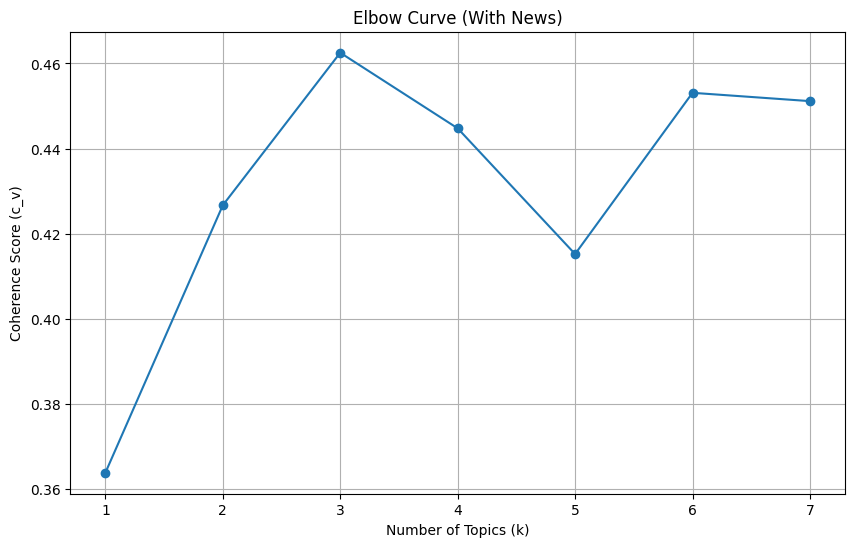

In [ ]:
# Plot creation for Elbow Curve of the "Combined Text Lemmas" column
def plot_coherence_curve(k_values, coherence_values):
  plt.figure(figsize=(10, 6))
  plt.plot(k_values, coherence_values, marker='o')
  plt.xlabel('Number of Topics (k)')
  plt.ylabel('Coherence Score (c_v)')
  plt.title('Elbow Curve (With News)')
  plt.grid(True)
  plt.show()
plot_coherence_curve(k_values, coherence_values)


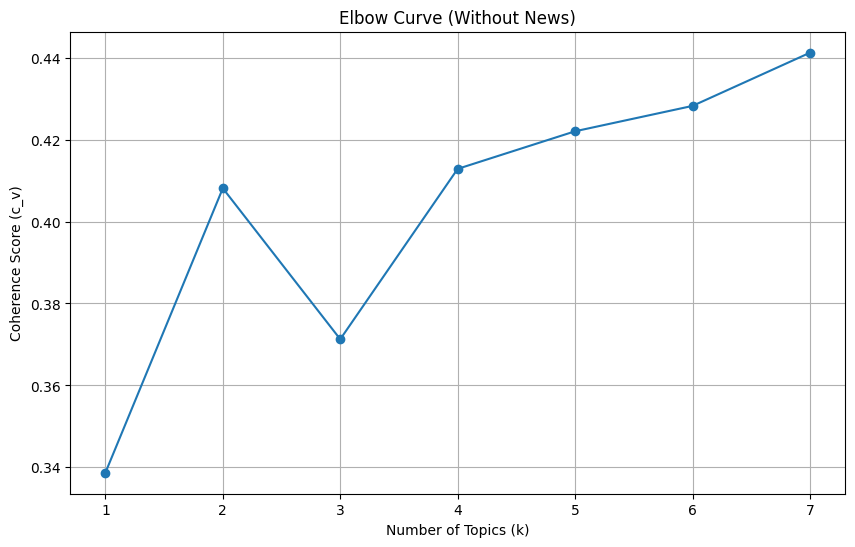

In [ ]:
# Plot creation for Elbow Curve of the "Combined Text W/O News Lemmas"
def plot_coherence_curve(k_values, coherence_values_without):
  plt.figure(figsize=(10, 6))
  plt.plot(k_values, coherence_values_without, marker='o')
  plt.xlabel('Number of Topics (k)')
  plt.ylabel('Coherence Score (c_v)')
  plt.title('Elbow Curve (Without News)')
  plt.grid(True)
  plt.show()
plot_coherence_curve(k_values, coherence_values_without)

In [ ]:
# Modify the get_topic_vector function to handle out-of-bounds topic IDs
def get_topic_vector(tokens, lda_model, dictionary, num_topics):
    bow = dictionary.doc2bow(tokens)
    topic_probs = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_vector = np.zeros(num_topics)
    for topic_id, prob in topic_probs:
        if topic_id < num_topics:  # Check if topic_id is within bounds
            topic_vector[topic_id] = prob
    return topic_vector

# Create separate columns for each dataset
df['topic_vector_with'] = df['Combined Text Lemmas'].apply(lambda tok: get_topic_vector(tok.split(), lda_model_with, dictionary, optimal_k))
df['topic_vector_without'] = df['Combined Text W/O News Lemmas'].apply(lambda tok: get_topic_vector(tok.split(), lda_model_without, dictionary_without, optimal_k_without))

# 3.5 Using LDA Topic Modelling Vectors for Binary Classification

Here we convert Class_Index into a binary classification to be used on the SVM and Regression models below. Changing the input to 0 and 1 is for computational convenience and of no ordered bearing.

In [ ]:
# Retrieve the target labels in order to begin classification with topic vectors
y = df['Class Index']
print("Unique labels:", y.unique())

Unique labels: [1 0]


In [ ]:
# Install other dependencies if not already installed from before
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

Here we begin comparing different performance metrics with the models.

As the assignment requested, we take in the topic_vectors and predict the Class Index variable of 0 or 1. Making it a binary classification.

In [ ]:
# Convert each topic_vector column to a NumPy array for classification
X_with = np.vstack(df['topic_vector_with'].values)
X_without = np.vstack(df['topic_vector_without'].values)

# Train/test split for the "with news" dataset
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(
    X_with, y, test_size=0.2, random_state=42)

# Classification 1: Logistic Regression (With News)
model_with = LogisticRegression(max_iter=1000)
model_with.fit(X_train_with, y_train_with)
y_pred_with = model_with.predict(X_test_with)

print("Classification Report (With News):")
print(classification_report(y_test_with, y_pred_with))

Classification Report (With News):
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5951
           1       0.88      0.85      0.87      6001

    accuracy                           0.87     11952
   macro avg       0.87      0.87      0.87     11952
weighted avg       0.87      0.87      0.87     11952



In [ ]:
# Classification 2: SVM (using a linear kernel)
# The linear kernel is optimal for binary classification
# Additionally the LDA topic modeller has already performed advanced feature extraction.
# SVMs can be optimal here as the topics are modelled into a concise number of groups (being 2 and 3)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_with, y_train_with)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_with)

# Evaluate the classifier
print("SVM Classification Report (Using LDA Topic Vectors with news):")
print(classification_report(y_test_with, y_pred_svm))

SVM Classification Report (Using LDA Topic Vectors with news):
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      5951
           1       0.87      0.86      0.87      6001

    accuracy                           0.87     11952
   macro avg       0.87      0.87      0.87     11952
weighted avg       0.87      0.87      0.87     11952



Doing the same model creation and comparison for the dataset that doesn't include news articles.

In [ ]:
# Train/test split for the "without news" dataset
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(
    X_without, y, test_size=0.2, random_state=42)

# Classification 1: Logistic Regression (Without News)
model_without = LogisticRegression(max_iter=1000)
model_without.fit(X_train_without, y_train_without)
y_pred_without = model_without.predict(X_test_without)

print("Classification Report (Without News):")
print(classification_report(y_test_without, y_pred_without))

Classification Report (Without News):
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      5951
           1       0.86      0.89      0.87      6001

    accuracy                           0.87     11952
   macro avg       0.87      0.87      0.87     11952
weighted avg       0.87      0.87      0.87     11952



In [ ]:
# Classification 2: SVM (using a linear kernel)
# The linear kernel is optimal for binary classification
# Additionally the LDA topic modeller has already performed advanced feature extraction.
svm_model_without = SVC(kernel='linear', probability=True, random_state=42)
svm_model_without.fit(X_train_without, y_train_without)

# Predict on the test set
y_pred_svm_without = svm_model_without.predict(X_test_without)

# Evaluate the classifier
print("SVM Classification Report (Using LDA Topic Vectors without news):")
print(classification_report(y_test_without, y_pred_svm_without))

SVM Classification Report (Using LDA Topic Vectors without news):
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      5951
           1       0.85      0.89      0.87      6001

    accuracy                           0.87     11952
   macro avg       0.87      0.87      0.87     11952
weighted avg       0.87      0.87      0.87     11952



# 4. Advanced Word Embeddings for Binary Classification

Step 4 Justification

For the "with news" dataset, our coherence test showed the best performance at K=3, while the "without news" dataset performed best at K=2.

We built final LDA models using these optimal values to capture the most coherent topics for each version. We then used the resulting topic distributions as features for text classification.

Logistic Regression and SVM were chosen for their simplicity, efficiency, and proven effectiveness with low-dimensional feature spaces.

In [ ]:
# Step 4 Justification
# For the "with news" dataset, our coherence test showed the best performance at K=3, while the "without news" dataset performed best at K=2.
# We built final LDA models using these optimal values to capture the most coherent topics for each version. We then used the resulting topic distributions as features for text classification.
# Logistic Regression and SVM were chosen for their simplicity, efficiency, and proven effectiveness with low-dimensional feature spaces.

In [ ]:
# Load pre-trained GloVe embeddings (50-dimensional version)
# Glove file will be submitted along with IPYNB file
embedding_index = {}
glove_file = 'glove.6B.50d.txt'
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
print("Loaded {} word vectors from GloVe.".format(len(embedding_index)))

Loaded 400000 word vectors from GloVe.


In [ ]:
# Define a function to compute the avg. embedding for each document
def compute_avg_embedding(text, embedding_index, embedding_dim=50):
  tokens = text.split()
  valid_vectors = [embedding_index[token] for token in tokens if token in embedding_index]
  if valid_vectors:
    return np.mean(valid_vectors, axis=0)
  else:
    return np.zeros(embedding_dim)

# Compute average embeddings for both columns from the dataset: with news and without news
df['avg_embedding_with'] = df['Combined Text Lemmas'].apply(lambda x: compute_avg_embedding(x, embedding_index))
df['avg_embedding_without'] = df['Combined Text W/O News Lemmas'].apply(lambda x: compute_avg_embedding(x, embedding_index))

# Convert the resulting embeddings to feature matrices (2D arrays)
x_embed_with = np.vstack(df['avg_embedding_with'].values)
x_embed_without = np.vstack(df['avg_embedding_without'].values)

# Set up the target labels (0 for sport, 1 for science/technology)
y = df['Class Index']
print("Unique labels:", y.unique())

Unique labels: [1 0]


### Here we develop the models using GLOVE word embeddings

In [ ]:
# For the "with news" embeddings:
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(x_embed_with, y, test_size=0.2, random_state=42)

# Logistic Regression classifier (with news) for avg. embeddings
lr_model_with = LogisticRegression(max_iter=1000)
lr_model_with.fit(X_train_with, y_train_with)
y_pred_lr_with = lr_model_with.predict(X_test_with)
print("Logistic Regression Classification Report (With News):")
print(classification_report(y_test_with, y_pred_lr_with))

# SVM classifier (with news) for avg. embeddings
svm_model_with = SVC(kernel='linear', probability=True, random_state=42)
svm_model_with.fit(X_train_with, y_train_with)
y_pred_svm_with = svm_model_with.predict(X_test_with)
print("SVM Classification Report (With News):")
print(classification_report(y_test_with, y_pred_svm_with))

Logistic Regression Classification Report (With News):
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5951
           1       0.88      0.87      0.88      6001

    accuracy                           0.88     11952
   macro avg       0.88      0.88      0.88     11952
weighted avg       0.88      0.88      0.88     11952

SVM Classification Report (With News):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5951
           1       0.88      0.88      0.88      6001

    accuracy                           0.88     11952
   macro avg       0.88      0.88      0.88     11952
weighted avg       0.88      0.88      0.88     11952



In [ ]:
# For the "without news" embeddings:
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(x_embed_without, y, test_size=0.2, random_state=42)

# Logistic Regression classifier(without news) for avg. embeddings
lr_model_without = LogisticRegression(max_iter=1000)
lr_model_without.fit(X_train_without, y_train_without)
y_pred_lr_without = lr_model_without.predict(X_test_without)
print("Logistic Regression Report (Without News):")
print(classification_report(y_test_without, y_pred_lr_without))

# SVM classifier (without news) for avg. embedding
svm_model_without = SVC(kernel='linear', probability=True, random_state=42)
svm_model_without.fit(X_train_without, y_train_without)
y_pred_svm_without = svm_model_without.predict(X_test_without)
print("SVM Classification Report (Without News):")
print(classification_report(y_test_without, y_pred_svm_without))


Logistic Regression Report (Without News):
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5951
           1       0.88      0.87      0.88      6001

    accuracy                           0.88     11952
   macro avg       0.88      0.88      0.88     11952
weighted avg       0.88      0.88      0.88     11952

SVM Classification Report (Without News):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5951
           1       0.88      0.88      0.88      6001

    accuracy                           0.88     11952
   macro avg       0.88      0.88      0.88     11952
weighted avg       0.88      0.88      0.88     11952



In [ ]:
# Advanced Word Embeddings for Classification (Step 5 Justification)
# We leverage pre-trained word embeddings (GloVe) to capture the semantic meaning of our text. By computing an average embedding for each document,
# we transform our text into a dense, low-dimensional vector that reflects the overall context and meaning of the words.
# This approach is advantageous compared to traditional bag-of-words methods, as it incorporates semantic relationships and reduces sparsity.

# We train two classifiers - Logistic Regression and Support Vector Machine (linear) for these word embeddings
# Both Logistic Regression and SVM achieve around 88% accuracy whether we include or exclude news-related content.
# This consistency suggests that removing news references does not significantly alter the core semantic structure captured by the GloVe embeddings

# Conclusion: This comparison helps us understand the impact of news-publication content on the semantic representation and overall classification accuracy.
# Future work could explore more advanced embeddings (such as BERT) and further hyperparameter tuning to potentially improve performance.

Advanced Word Embeddings for Classification (Step 5 Justification)
We leverage pre-trained word embeddings (GloVe) to capture the semantic meaning of our text. By computing an average embedding for each document, we transform our text into a dense, low-dimensional vector that reflects the overall context and meaning of the words. This approach is advantageous compared to traditional bag-of-words methods, as it incorporates semantic relationships and reduces sparsity.

We train two classifiers - Logistic Regression and Support Vector Machine (linear) for these word embeddings. Both Logistic Regression and SVM achieve around 88% accuracy whether we include or exclude news-related content. This consistency suggests that removing news references does not significantly alter the core semantic structure captured by the GloVe embeddings Additionally, these two models are both highly effective for binary classification tasks like we are performing. It is also prudent to keep the models consistent between tasks as the end goal is the best but the input data differs. This offers a better comparison of quality of vectorization on the data.

Conclusion: This comparison helps us understand the impact of news-related content on the semantic representation and overall classification accuracy. Future work could explore more advanced embeddings (such as BERT) and further hyperparameter tuning to potentially improve performance.

In [ ]:
import seaborn as sns

# Sample evaluation metrics for models using LDA topic distributions and
# advanced word embeddings.
results_with = {
    "LDA LR": {"Accuracy": 0.87, "Precision": 0.87, "Recall": 0.87, "F1": 0.87},
    "LDA SVM": {"Accuracy": 0.87, "Precision": 0.84, "Recall": 0.87, "F1": 0.87},
    "Embeddings LR": {"Accuracy": 0.88, "Precision": 0.88, "Recall": 0.88, "F1": 0.88},
    "Embeddings SVM": {"Accuracy": 0.88, "Precision": 0.88, "Recall": 0.88, "F1": 0.88}
}

results_without = {
    "LDA LR": {"Accuracy": 0.87, "Precision": 0.87, "Recall": 0.87, "F1": 0.87},
    "LDA SVM": {"Accuracy": 0.87, "Precision": 0.87, "Recall": 0.87, "F1": 0.87},
    "Embeddings LR": {"Accuracy": 0.88, "Precision": 0.88, "Recall": 0.88, "F1": 0.88},
    "Embeddings SVM": {"Accuracy": 0.88, "Precision": 0.88, "Recall": 0.88, "F1": 0.88}
}

# Convert results dictionary to a DataFrame
df_with_news = pd.DataFrame(results_with).T
df_with_news.index.name = 'Model'
df_with_news.reset_index(inplace=True)
df_with_news["Dataset"] = "With News"

df_without_news = pd.DataFrame(results_without).T
df_without_news.index.name = 'Model'
df_without_news.reset_index(inplace=True)
df_without_news["Dataset"] = "Without News"

# Combine both DataFrames for comparison
combined_df = pd.concat([df_with_news, df_without_news], ignore_index=True)

# Reshape the dataframe for plotting (melting)
melted_df = combined_df.melt(id_vars=['Model', 'Dataset'], var_name='Metric', value_name='Score')

### Here we engineer some visualizations.

<ipython-input-49-c30df5aa47ed>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model", ci=None)


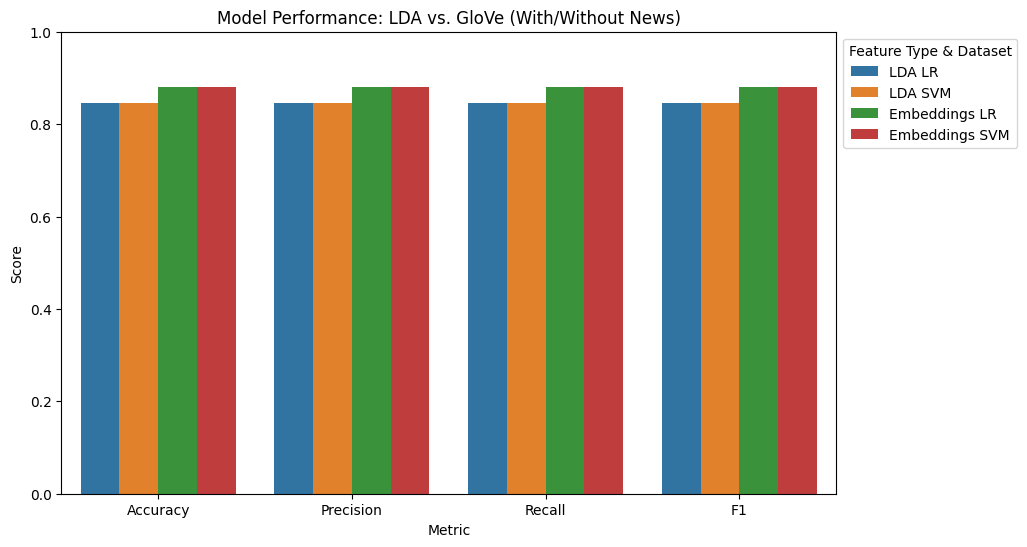

In [ ]:
# Create a grouped bar plot to analyze comparison for "With news" and "Without News" models between GloVe and LDA
plt.figure(figsize=(10,6))
sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model", ci=None)
plt.title("Model Performance: LDA vs. GloVe (With/Without News)")
plt.ylim(0, 1)
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Feature Type & Dataset", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# Step 7: Final Insights & Conclusions

Binary classification results show that using LDA topic modeling vectors achieves an average of 87% for accuracy, precision, recall, and F1-score. In contrast, the models built with advanced word embeddings (GloVe) reach about 88% on all these metrics. Although the difference is slight, it suggests that the richer semantic information captured by embeddings gives a modest performance edge over the thematic features provided by LDA. This indicates that both approaches are effective for binary text classification, with embeddings slightly outperforming LDA in capturing nuanced relationships in the text.

Future Improvements


*   Using a smaller dataset to test coherence score could reduce computation time
*   Advanced Methods like BERT or combining LDA topics with embeddings could further enhance performance
*   Further hyperparameter tuning and data diversity could also improve model generalization (increasing data size)
*   Opting to use deep-learning models like Autoencoders can be a better place to start in replacement of LDA topic modelling.
*   Building upon Autoencoders, we could also use a tensorflow deep-learning neural network model as a binary classifier such as tf.keras.Sequential. This would also be robust to outliers and prioritize relevant relationships more highly.
*   Removal of excessively long words. There are some words that weren't cleaned out as the code was too complex for the Google Colab runtime.
*   Similarly, Spellchecker should've been used on the data to aid data density and align more words with one another to improve output. However, all attempted spellcheckers, even while using chunking extensively, were crashing the Google Colab runtime.